In [ ]:
!pip install top2vec
!pip install top2vec[sentence_encoders] --use-deprecated=legacy-resolver
!pip install top2vec[sentence_transformers]
# !pip install plotly==5.2.1
# !pip install -U kaleido

In [ ]:
import json, os, re, time,regex
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from natsort import natsorted

In [ ]:
import seaborn as sns
import networkx as nx
import umap
import hdbscan

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
#model = Top2Vec(documents= cleaned_docs, speed='learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', kmeans_args = {"n_clusters": 15, "init": "k-means++"})

In [ ]:
with open('/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/upnishads_texts/eknath_datalist.json', 'r') as f:
  data_dict = json.load(f)

In [ ]:
data_list = []
data_dict_new = {}
def get_data_list(d):
  for k, v in d.items():
    x = "{}".format(k)
    if isinstance(v, dict):
      get_data_list(v)
    else:
      if len(k) < 3:
        #doc_list = getdoc(v)
        if len(v.strip().split()) > 3:
          data_list.append(v)
get_data_list(data_dict)
len(data_list)

645

In [ ]:
def nested_dict_pairs_iterator(dict_obj):
    ''' This function accepts a nested dictionary as argument
        and iterate over all values of nested dictionaries
    '''
    # Iterate over all key-value pairs of dict argument
    for key, value in dict_obj.items():
        # Check if value is of dict type
        if isinstance(value, dict):
            # If value is dict then iterate over all its values
            for pair in  nested_dict_pairs_iterator(value):
                yield [key, *pair]
        else:
            # If value is not dict type then yield the value
            yield [key, value]
#Loop through all key-value pairs of a nested dictionary
data_dict_new = {}
for pair in nested_dict_pairs_iterator(data_dict):
    data_dict_new['-'.join(pair[:-1])] = pair[-1]
with open('eknath_easwaran_upanishads.json', 'w') as fp:
  json.dump(data_dict_new, fp, indent = 4)

In [ ]:
def get_list_intro(data, num_words = 100):
  res = []
  words = data.strip().split(" ")
  i = 0
  while(i < (len(words))):
    if (i+num_words) < len(words):
      res.append(" ".join(words[i:i+num_words]))
      i = i+num_words
    else:
      res.append(" ".join(words[i:]))
      i = i+num_words
  return res

data_list_all = []
def get_data_list_all(d):
  for k, v in d.items():
    if isinstance(v, dict):
      get_data_list_all(v)
    else:
      if len(k) < 3 and not isinstance(v, list):
        #doc_list = getdoc(v)
        if len(v.strip().split()) > 3:
          data_list_all.append(v)
      else:
        list_intro = get_list_intro(v)
        data_list_all.extend(list_intro)
get_data_list_all(data_dict)
len(data_list_all)

889

In [ ]:
def get_data_dict_all(data_dict_new):
  '''
  - get the dictionary of all the upanishads and introduction from new data dictionary
  - for intro 100 words is considered as 1 documents
  '''
  data_dict_all = {}
  for key, value in data_dict_new.items():
    if ('intro' in key) or ('Afterword' in key):
      list_intro = get_list_intro(value)
      for i, x in enumerate(list_intro):
        data_dict_all[key+'-'+str(i)] = x
    else:
      data_dict_all[key] = value
  return data_dict_all
data_dict_all = get_data_dict_all(data_dict_new)
data_list_all = list(data_dict_all.values())
len(data_list_all)

880

In [ ]:
def remove_stop_words(data):
  word_list = word_tokenize(data)
  stops = set(stopwords.words("english"))
  filtered_words = [word for word in word_list if word not in stops]
  return " ".join(filtered_words)

def clean(data):
  """
  Args:
  data: single sentence
  """
  data = re.sub(r'[^\x00-\x7f]',r'', data)
  data = data.replace('\x0c', '')
  data = data.replace('\x0d', '')
  data = data.replace('\f', '')
  data = data.replace('\n', ' ')
  data = re.sub('[V]{1,}[.].*?[)]', '', data)
  data = re.sub('[I]{1,}[.].*?[)]', '', data)
  data = re.sub('IV{1,}[.].*?[)]', '', data)
  data = re.sub('X{1,}[.].*?[)]', '', data)
  data = re.sub('M[.]N[.]', '', data)
  # data = re.sub('[.][ ][.][ ][.][ ][.]', '', data)
  # data = re.sub('[.][ ][.][ ][.]', '', data)
  # data = re.sub('[.][ ][.]', '', data)
  # remove all other symbols numbers and white spaces
  data = "".join([character if (character.isalpha() or character == "." or character ==" " or character == "\n") else " " for character in data])
  #remove extra spaces in the middle of the sentence
  data = data.replace('.', ' ')
  data = re.sub(" +", " ", data)
  #remove extra spaces in the beginning
  data = data.strip()
  # data = data.lower()
  # data = remove_stop_words(data)
  return data

In [ ]:
# re.findall('[.][ ][.][ ][.][ ][.]', '\n'.join(data_list_all))

In [ ]:
cleaned_data_dict = {}
for key, value in data_dict_all.items():
  cleaned_data_dict[key] = clean(value)

with open('eknath_easwaran_upanishads_cleaned.json', 'w') as fp:
  json.dump(cleaned_data_dict, fp, indent = 4)
# cleaned_data_dict

In [ ]:
def get_upanishads_dict(data_dict):
  upanishads_dict = defaultdict(str)
  for key, value in data_dict.items():
    if not 'Afterword' in key:
      if not 'FOUR' in key:
        name = key.strip().split('-')[0]
        upanishads_dict[name] = upanishads_dict[name]+value+'\n'
      elif not 'intro' in key:
        name = key.strip().split('-')[1]
        name = name.strip().split(" ")[1]
        upanishads_dict[name] = upanishads_dict[name]+value+'\n'
  return upanishads_dict

def get_word_docs_counts_upanishad_wise(upanishads_dict):
  upan_words_num = {}
  upan_docs_num = {}
  for key, text in upanishads_dict.items():
    words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    upan_words_num[key] = len(words)
    #get num of docs
    upan_docs_num[key] = len(text.split('\n'))
  return upan_words_num, upan_docs_num

In [ ]:
upanishads_dict = get_upanishads_dict(cleaned_data_dict)
upan_words_num, upan_docs_num = get_word_docs_counts_upanishad_wise(upanishads_dict)
print(upan_words_num, upan_docs_num)

{'ISHA': 548, 'KATHA': 2824, 'BRIHADARANYAKA': 2063, 'CHANDOGYA': 3070, 'SHVESTASHVATARA': 2129, 'MUNDAKA': 1323, 'MANDUKYA': 498, 'KENA': 758, 'PRASHNA': 1550, 'TAITTIRIYA': 1906, 'AITAREYA': 889, 'Tejobindu': 164, 'Atma': 164, 'Amritabindu': 221, 'Paramahamsa': 229} {'ISHA': 20, 'KATHA': 129, 'BRIHADARANYAKA': 69, 'CHANDOGYA': 126, 'SHVESTASHVATARA': 116, 'MUNDAKA': 68, 'MANDUKYA': 19, 'KENA': 41, 'PRASHNA': 72, 'TAITTIRIYA': 54, 'AITAREYA': 39, 'Tejobindu': 6, 'Atma': 4, 'Amritabindu': 23, 'Paramahamsa': 5}


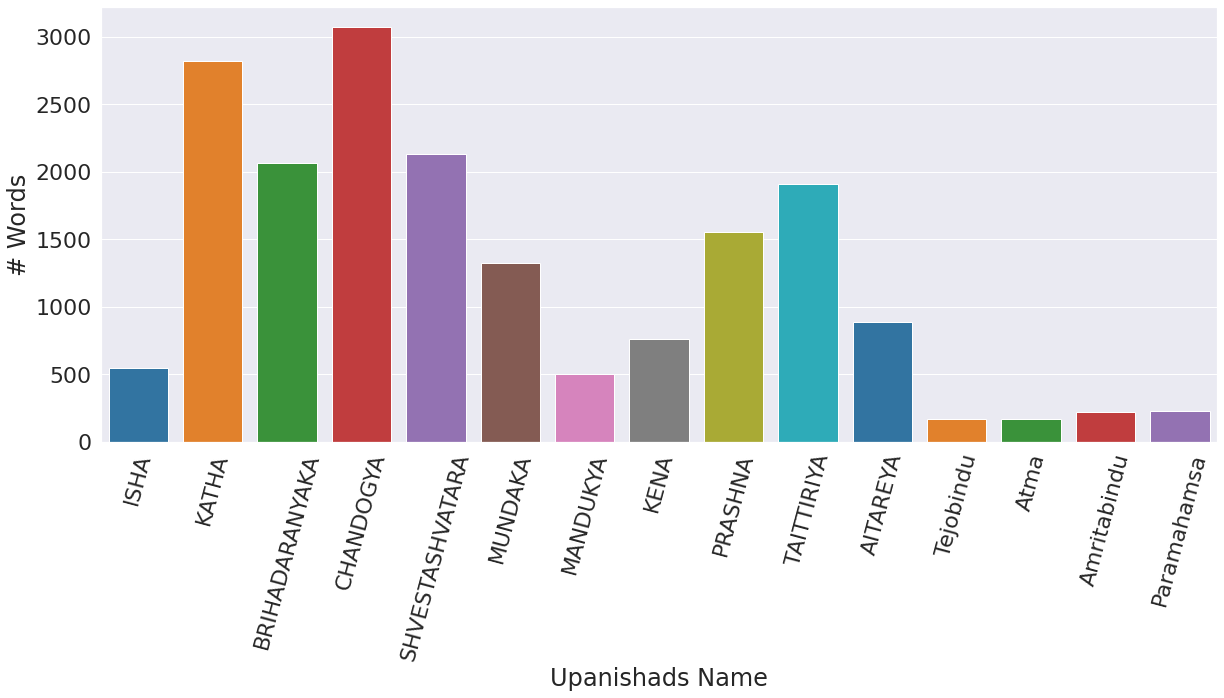

In [ ]:
sns.set(font_scale=2)
words_num_dict = {'Upanishads':[key for key in upan_words_num.keys()], '# Words':list(upan_words_num.values())}
df_words_num = pd.DataFrame(words_num_dict)
x_tick = [key for key in upan_words_num.keys()]
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num, palette='tab10')
# ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
_ = ax.set_xticklabels(x_tick, rotation=75)
plt.xlabel("Upanishads Name")
plt.savefig("word_count_eknath_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
# cleaned_docs_upan = [clean(doc) for doc in data_list]
cleaned_docs_all_upan = [clean(doc) for doc in data_list_all]
# print(len(cleaned_docs_upan))
cleaned_docs_all_upan = [" ".join(word_tokenize(x)) for x in cleaned_docs_all_upan if (len(word_tokenize(x)) > 3)]
len(cleaned_docs_all_upan)

878

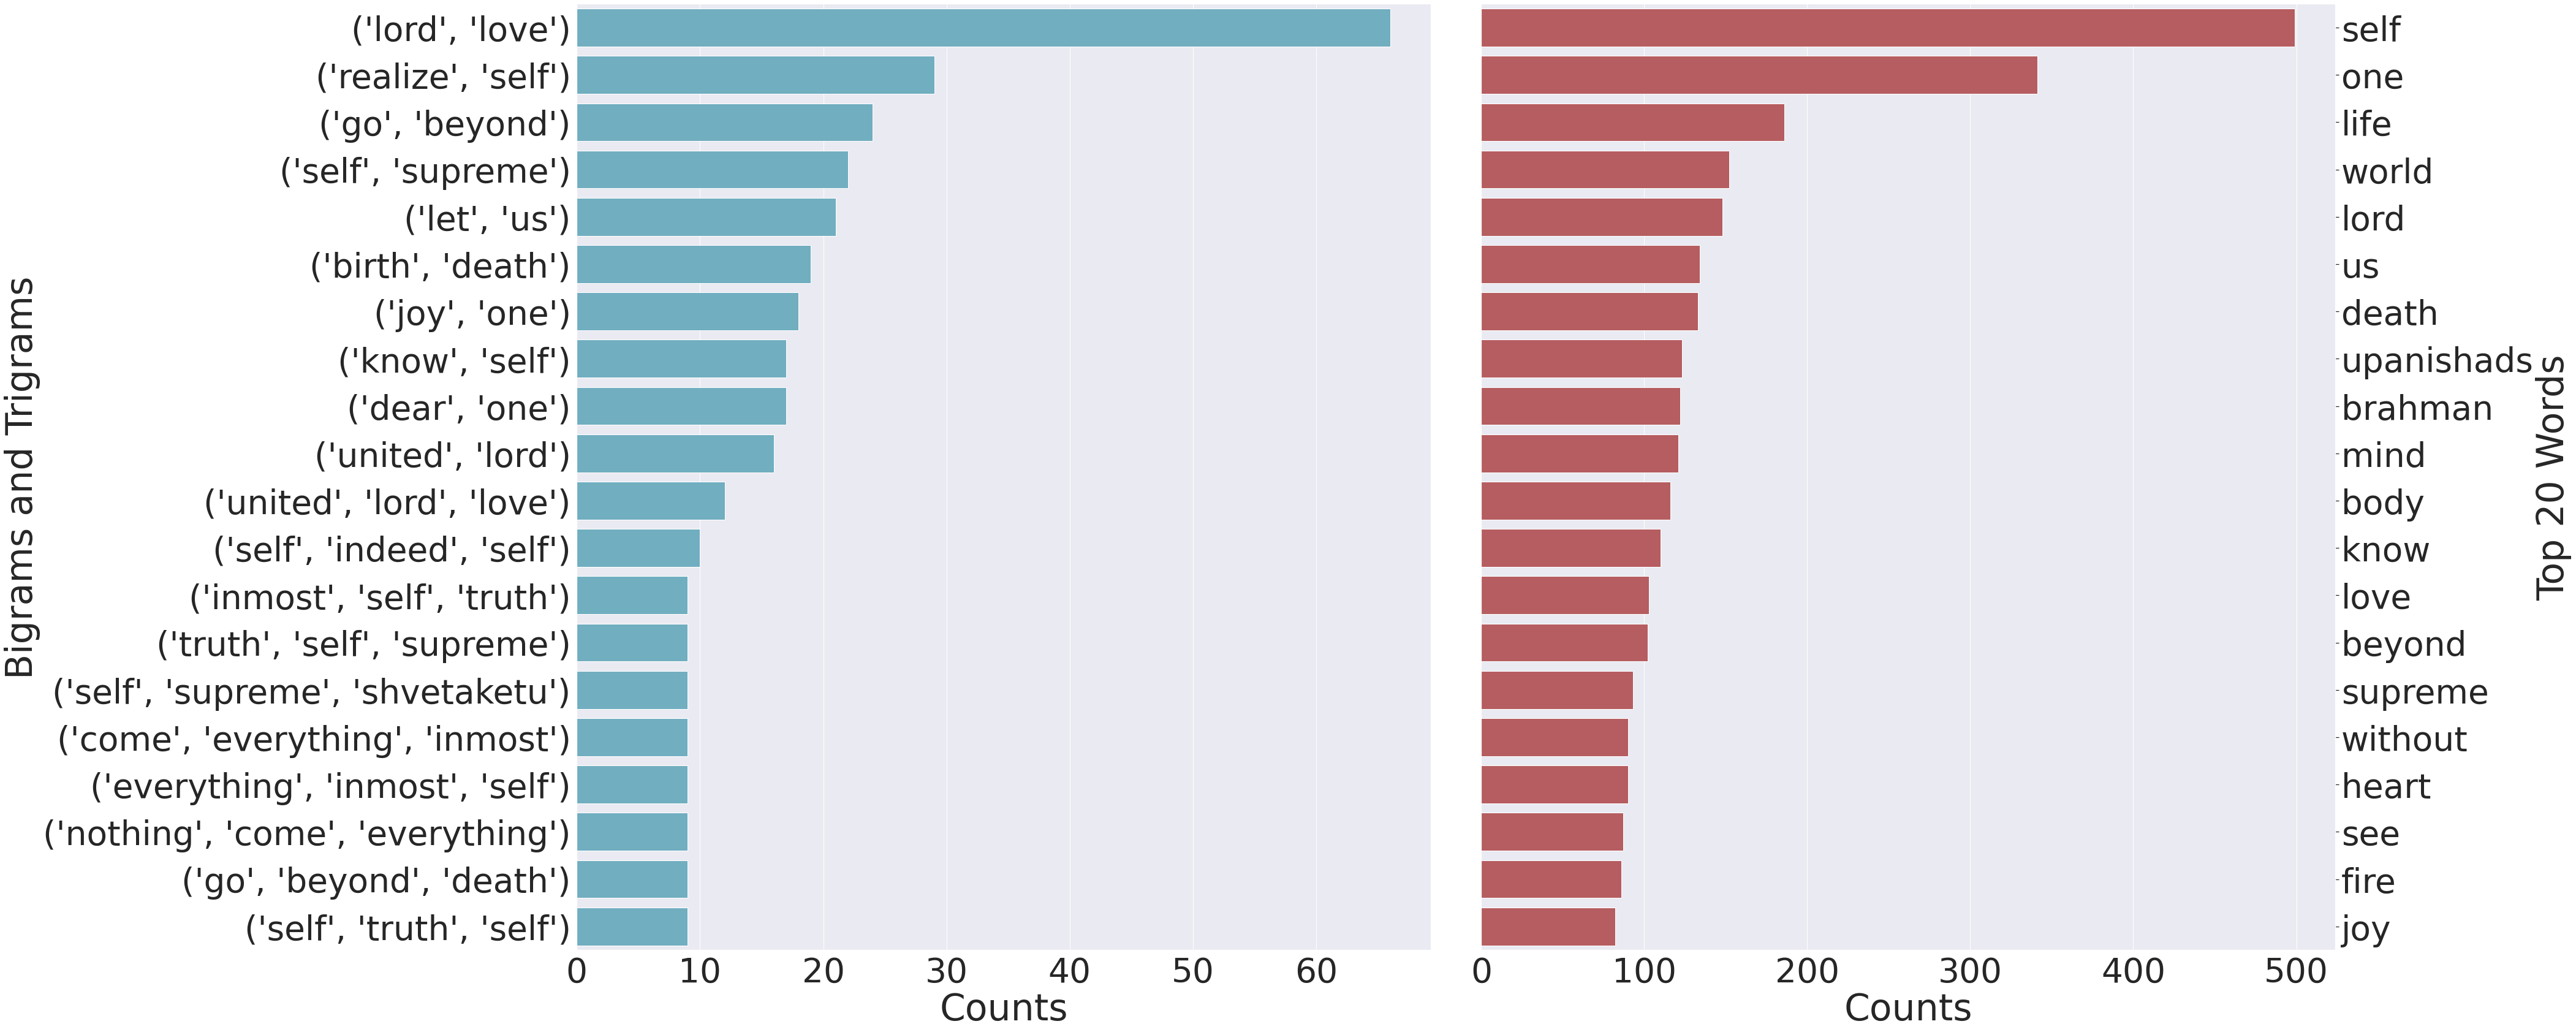

In [ ]:
def plot_uni_bi_trigram(cleaned_data_dict, file_name = "uni_bi_trigram_eknath_upanishads.pdf"):
  cleaned_text = '\n'.join(list(cleaned_data_dict.values()))
  cleaned_text = cleaned_text.lower()
  sns.set(font_scale=5)
  f, axs = plt.subplots(1,2,
                      figsize=(60,25),
                      gridspec_kw=dict(width_ratios=[1, 1]))
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
  series_trigram = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
  listbg1 = list(series_bigram.index)
  listbg2 = list(series_trigram.index)
  listtg1 = list(series_bigram.values)
  listtg2 = list(series_trigram.values)
  dict_ngram = {'Ngrams': listbg1+ listbg2, 
                'Counts': listtg1+ listtg2}
  df_ngram_count = pd.DataFrame(dict_ngram)
  # fig = plt.figure(figsize=(16, 8))
  # sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c", ax = axs[0])
  axs[0].set_xlabel("Counts")
  axs[0].set_ylabel("Bigrams and Trigrams")
  # plt.savefig("ngram_ten_upanishads.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

  # stopwords_list = stopwords.words('english')
  # stopwords_list.extend(['I', 'The', 'Him', 'He'])
  # words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
  df_unigram = pd.DataFrame({'Top 20 Words': [x[0] for x in series_unigram.index], 'Counts': series_unigram.values})
  # fig = plt.figure(figsize=(16, 8))
  
  axs[1].yaxis.tick_right()
  axs[1].yaxis.set_label_position("right")
  # axs[1].set_xlabel("Counts")
  axs[1].set_ylabel('Top 20 Words')
  # axs[1].title.set_position([4, 4])
  # axs[1].yaxis.labelpad = 25
  sns.barplot(x="Counts", y='Top 20 Words', data=df_unigram, color="r", ax=axs[1])
  sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c", ax = axs[0])
  axs[0].set_xlabel("Counts")
  axs[0].set_ylabel("Bigrams and Trigrams")
  # f.text(0.5, 0.04, "Counts of the Bi-gram Tri-gram and \n the top 20 words of the Ten Upanishads", ha='center')
  f.tight_layout()
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=f.get_facecolor(), edgecolor='none')
plot_uni_bi_trigram(cleaned_data_dict)

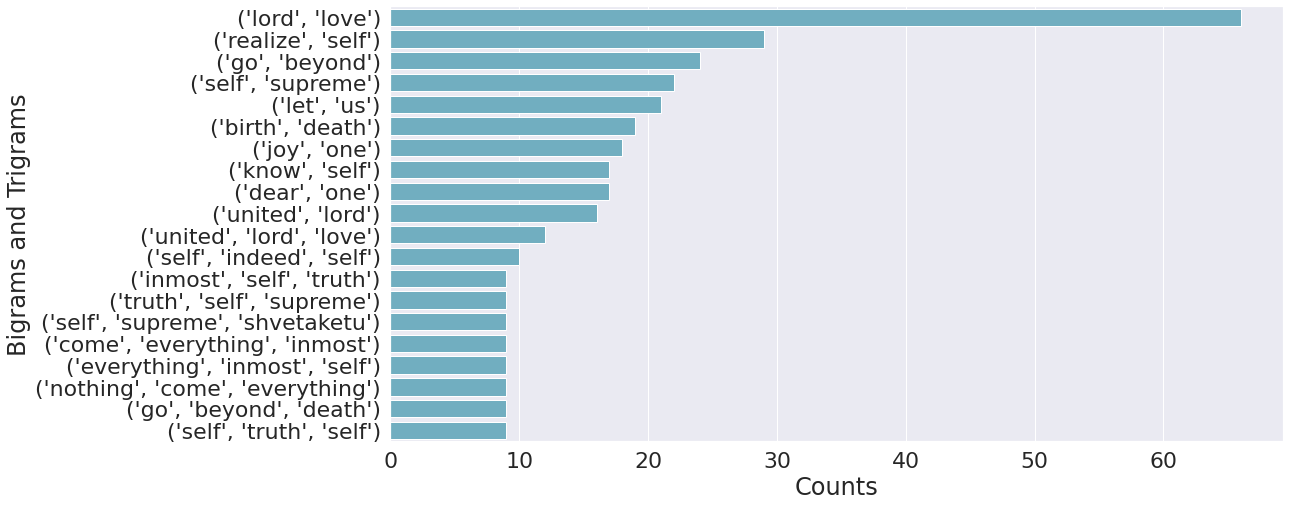

In [ ]:
def plot_ngram(cleaned_data_dict, file_name = "ngram_eknath_upanishads.pdf"):
  sns.set(font_scale=2)
  cleaned_text = '\n'.join(list(cleaned_data_dict.values()))
  cleaned_text = cleaned_text.lower()
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_bigram = (pd.Series(nltk.ngrams(words, 2)).value_counts())[:10]
  series_trigram = (pd.Series(nltk.ngrams(words, 3)).value_counts())[:10]
  listbg1 = list(series_bigram.index)
  listbg2 = list(series_trigram.index)
  listtg1 = list(series_bigram.values)
  listtg2 = list(series_trigram.values)
  dict_ngram = {'Ngrams': listbg1+ listbg2, 
                'Counts': listtg1+ listtg2}
  df_ngram_count = pd.DataFrame(dict_ngram)
  fig = plt.figure(figsize=(16, 8))
  ax = sns.barplot(x="Counts", y="Ngrams", data=df_ngram_count, color="c")
  plt.xlabel("Counts")
  plt.ylabel("Bigrams and Trigrams")
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
plot_ngram(cleaned_data_dict)

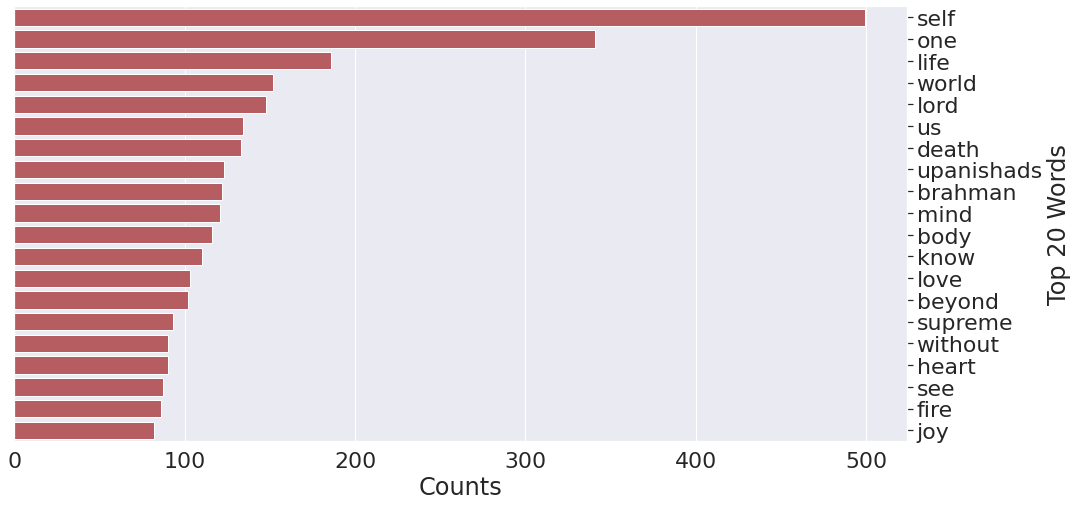

In [ ]:
def plot_unigram(cleaned_data_dict, file_name = "unigram_eknath_upanishads.pdf"):
  sns.set(font_scale=2)
  cleaned_text = '\n'.join(list(cleaned_data_dict.values()))
  cleaned_text = cleaned_text.lower()
  stopwords_list = stopwords.words('english')
  stopwords_list.extend(['I', 'The', 'Him', 'He'])
  words = [word for word in word_tokenize(cleaned_text) if word not in stopwords_list]
  series_unigram = (pd.Series(nltk.ngrams(words, 1)).value_counts())[:20]
  df_unigram = pd.DataFrame({'Top 20 Words': [x[0] for x in series_unigram.index], 'Counts': series_unigram.values})
  fig = plt.figure(figsize=(16, 8))
  ax = sns.barplot(x="Counts", y='Top 20 Words', data=df_unigram, color="r")
  plt.xlabel("Counts")
  plt.ylabel('Top 20 Words')
  ax.yaxis.set_label_position("right")
  ax.yaxis.tick_right()
  plt.savefig(file_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
plot_unigram(cleaned_data_dict)

## Bhagavad Geeta Analysis

In [ ]:
path = '/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/gita_cleaned/verses_eknath_easwaran.txt'
with open(path, 'r') as f:
  data_gita = f.read()

In [ ]:
def get_chapter_dict(data_gita):
  chapter_dict = defaultdict(str)
  chapter_gita_list = data_gita.split("\n\n")
  for chapter in chapter_gita_list:
    chapter_text_list = chapter.strip().split('\n')
    chapter_dict[chapter_text_list[0]] = '\n'.join(chapter_text_list[1:])
  return chapter_dict

def get_word_docs_counts_chapter_wise(data_gita):
  gita_words_num = {}
  gita_docs_num = {}
  chapter_dict = get_chapter_dict(data_gita)
  for key, text in chapter_dict.items():
    words = [word for word in word_tokenize(text) if word not in stopwords.words('english')]
    gita_words_num[key] = len(words)
    #get num of docs
    gita_docs_num[key] = len(text.split('\n'))
  return gita_words_num, gita_docs_num
gita_words_num, gita_docs_num = get_word_docs_counts_chapter_wise(data_gita)
# gita_words_num, gita_docs_num

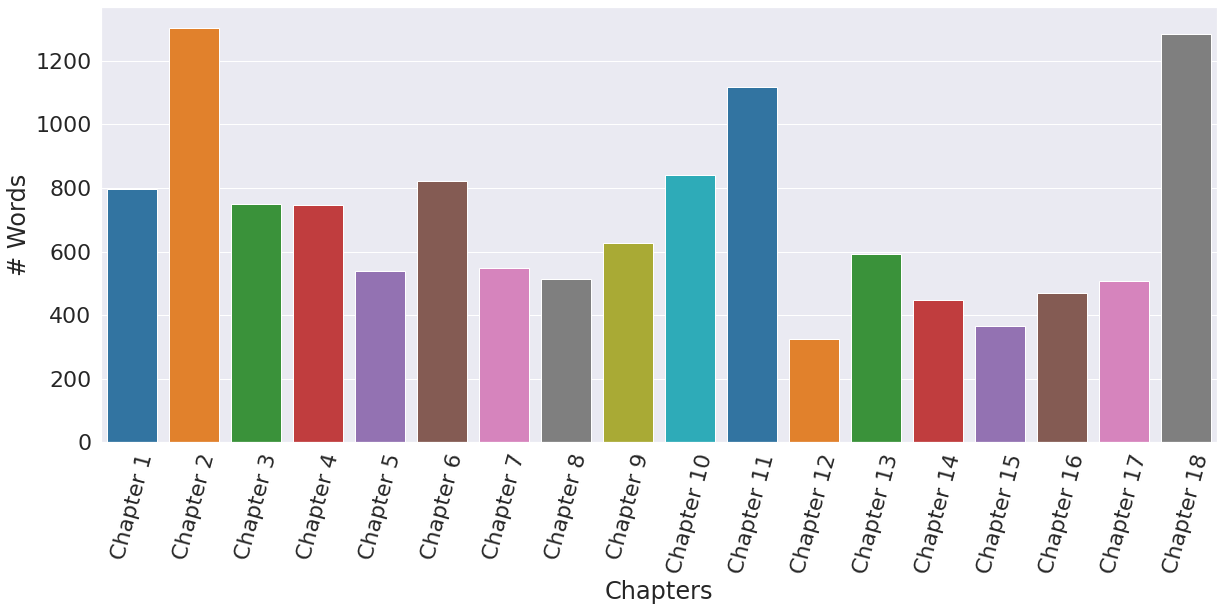

In [ ]:
words_num_dict = {'Chapters':[key for key in gita_words_num.keys()], '# Words':list(gita_words_num.values())}
df_words_num = pd.DataFrame(words_num_dict)
x_tick = [key for key in gita_words_num.keys()]
fig = plt.figure(figsize=(20, 8))
ax = sns.barplot(x="Chapters", y="# Words", data=df_words_num, palette='tab10')
# ax = sns.barplot(x="Upanishads", y="# Words", data=df_words_num)
_ = ax.set_xticklabels(x_tick, rotation=75)
plt.xlabel("Chapters")
plt.savefig("word_count_eknath_gita.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

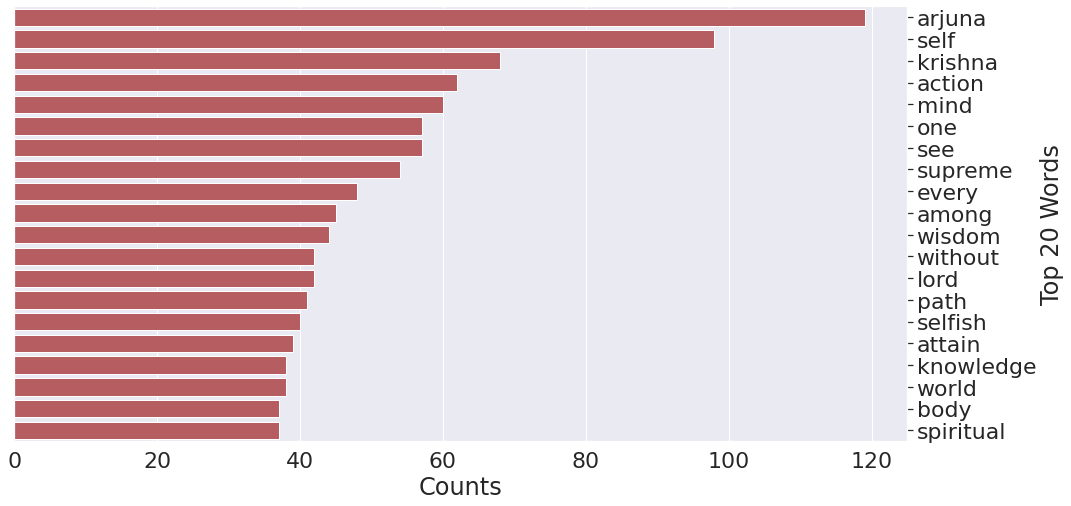

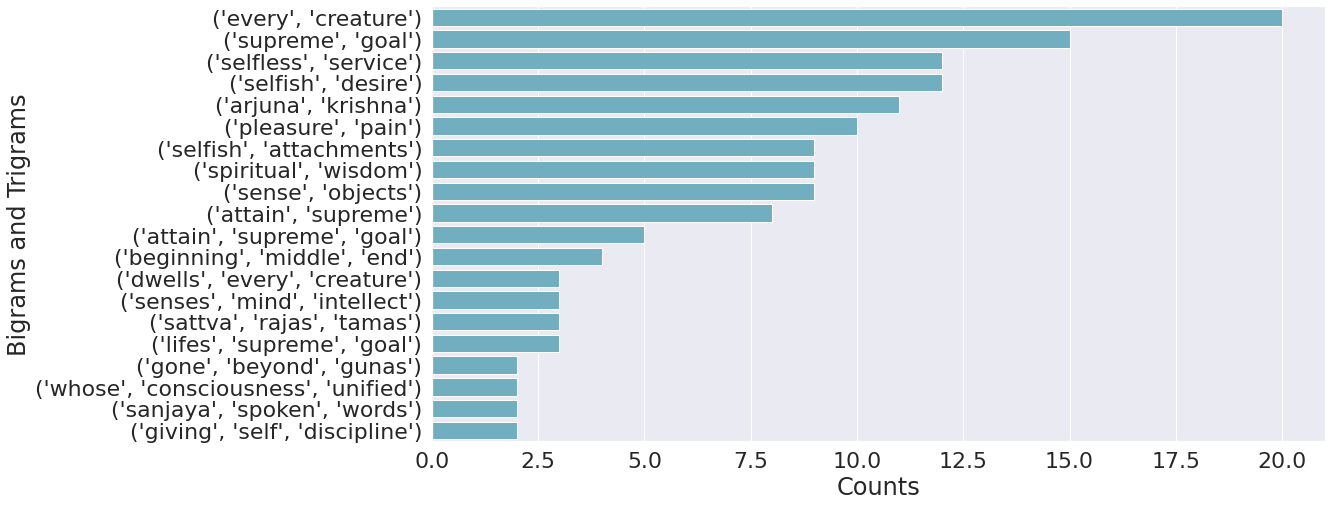

In [ ]:
chapter_dict = get_chapter_dict(data_gita)
cleaned_chapter_dict = {x:remove_stop_words(clean(y).lower()) for x, y in chapter_dict.items()}
plot_unigram(cleaned_chapter_dict, file_name = "unigram_eknath_gita.pdf")
plot_ngram(cleaned_chapter_dict, file_name = "ngram_eknath_gita.pdf")

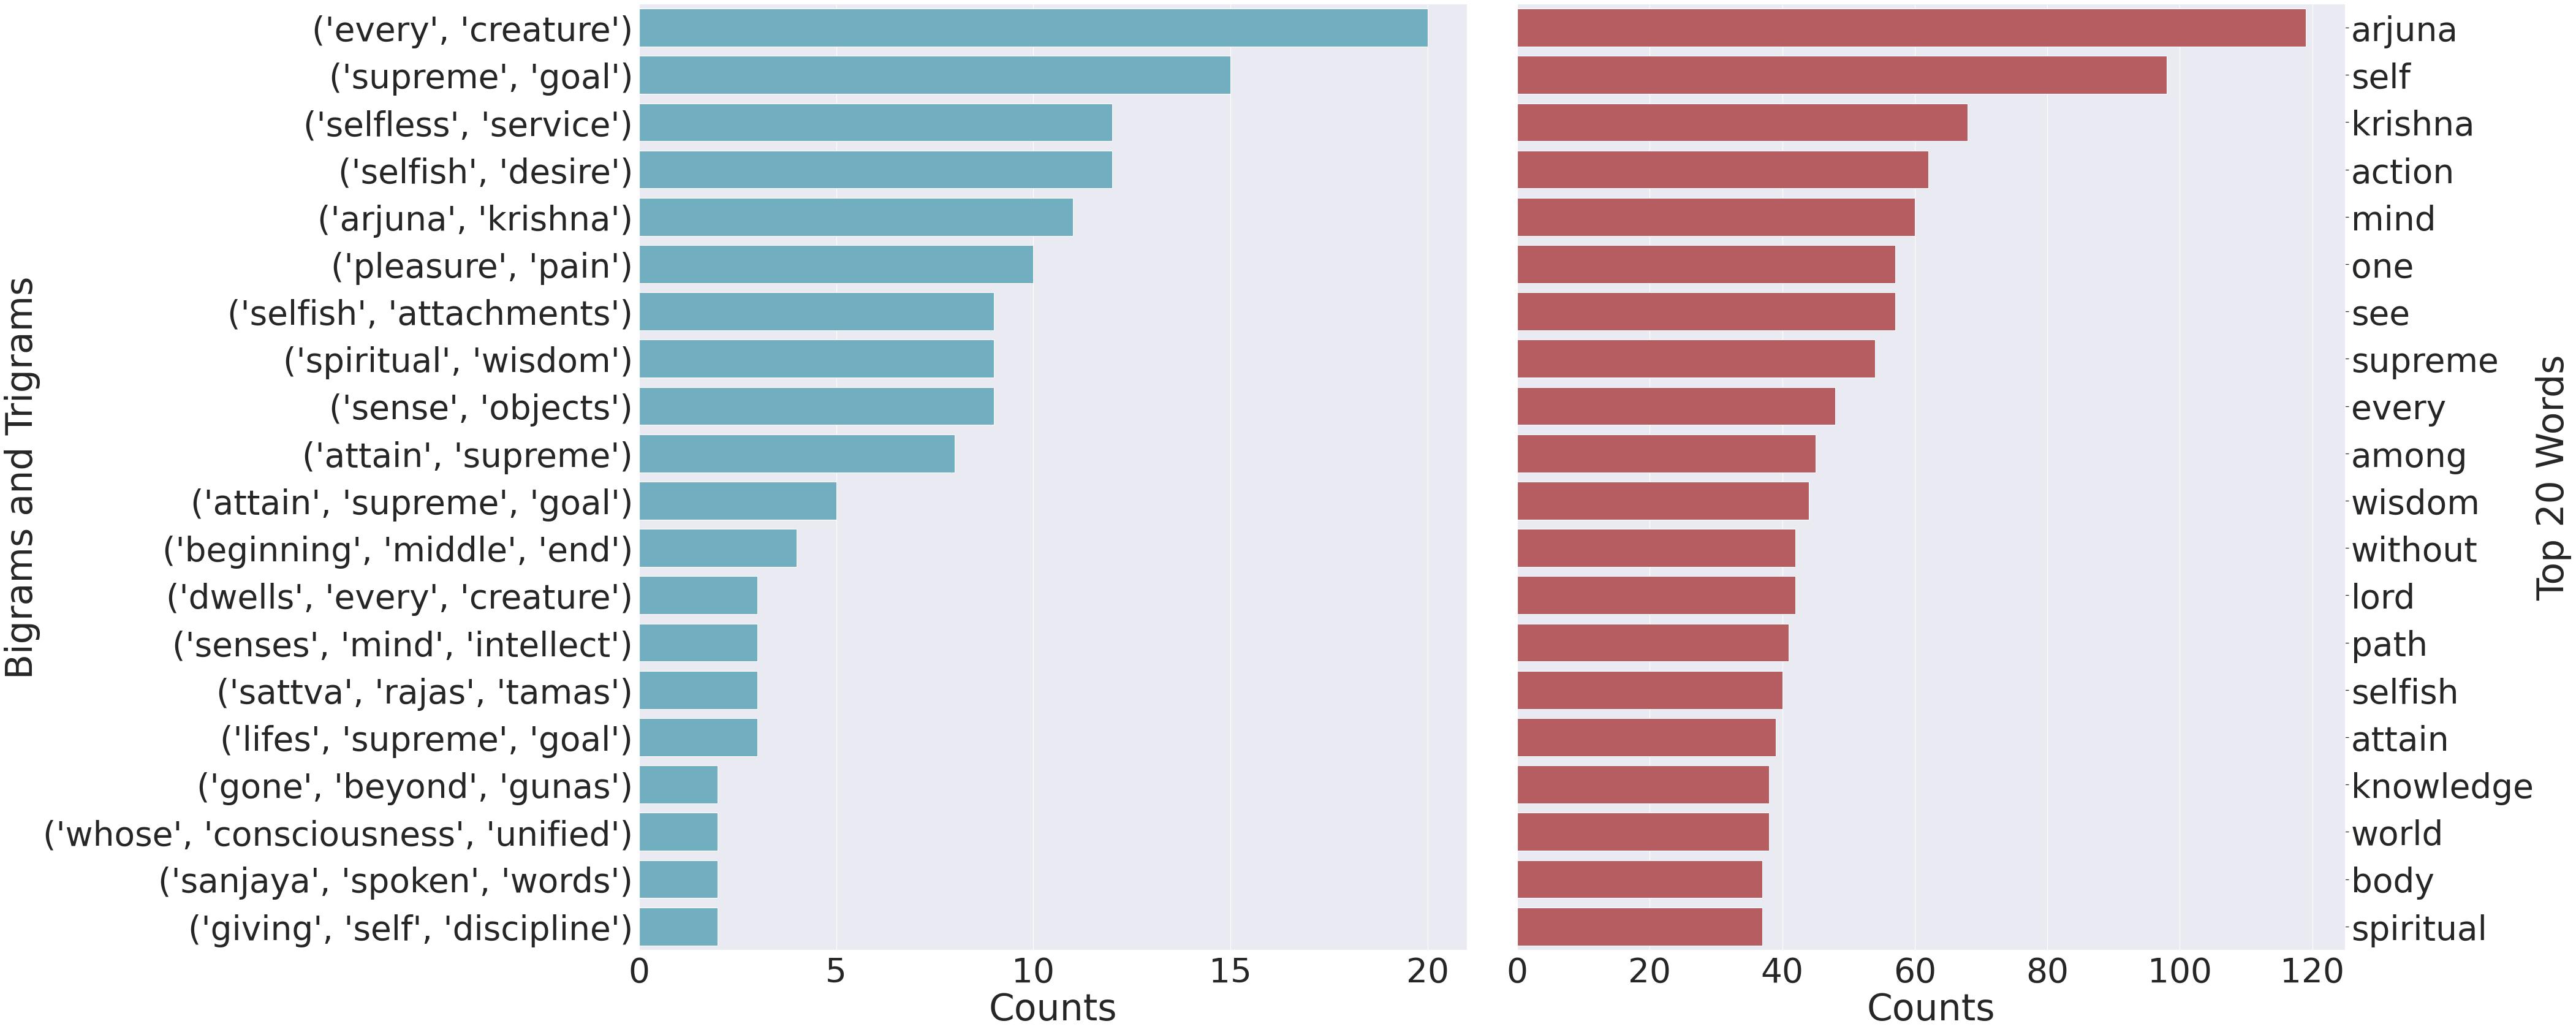

In [ ]:
plot_uni_bi_trigram(cleaned_chapter_dict, file_name = "uni_bi_trigram_eknath_gita.pdf")

In [ ]:
# data_gita_list

In [ ]:
from topic_model import TopicModel

In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
model.get_num_topics()

2021-11-29 02:11:35,872 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-29 02:11:46,912 - top2vec - INFO - Finding dense areas of documents
2021-11-29 02:11:46,955 - top2vec - INFO - Finding topics


18

In [ ]:
# topic_words, word_scores, topic_nums = model.get_topics()
# topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())
# topic_words
# for topic in topic_nums:
#   model.generate_topic_wordcloud(topic)

In [ ]:
cluster = model.get_cluster()

In [ ]:
umap_args = {
      "n_neighbors": 10,
      "n_components": 2, # 5 -> 2 for plotting 
      "metric": "cosine",
      "random_state":42
      }
umap_data = umap.UMAP(**umap_args).fit_transform(model._get_document_vectors(norm=False))

In [ ]:
# fig = cluster.condensed_tree_.plot()
color_palette = sns.color_palette('deep', 18)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cluster.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, cluster.probabilities_)]
fig = plt.figure(figsize=(24,16))
ax = fig.add_subplot(111)
ax.scatter(*umap_data.T, s=100, linewidth=0, c=cluster_member_colors)

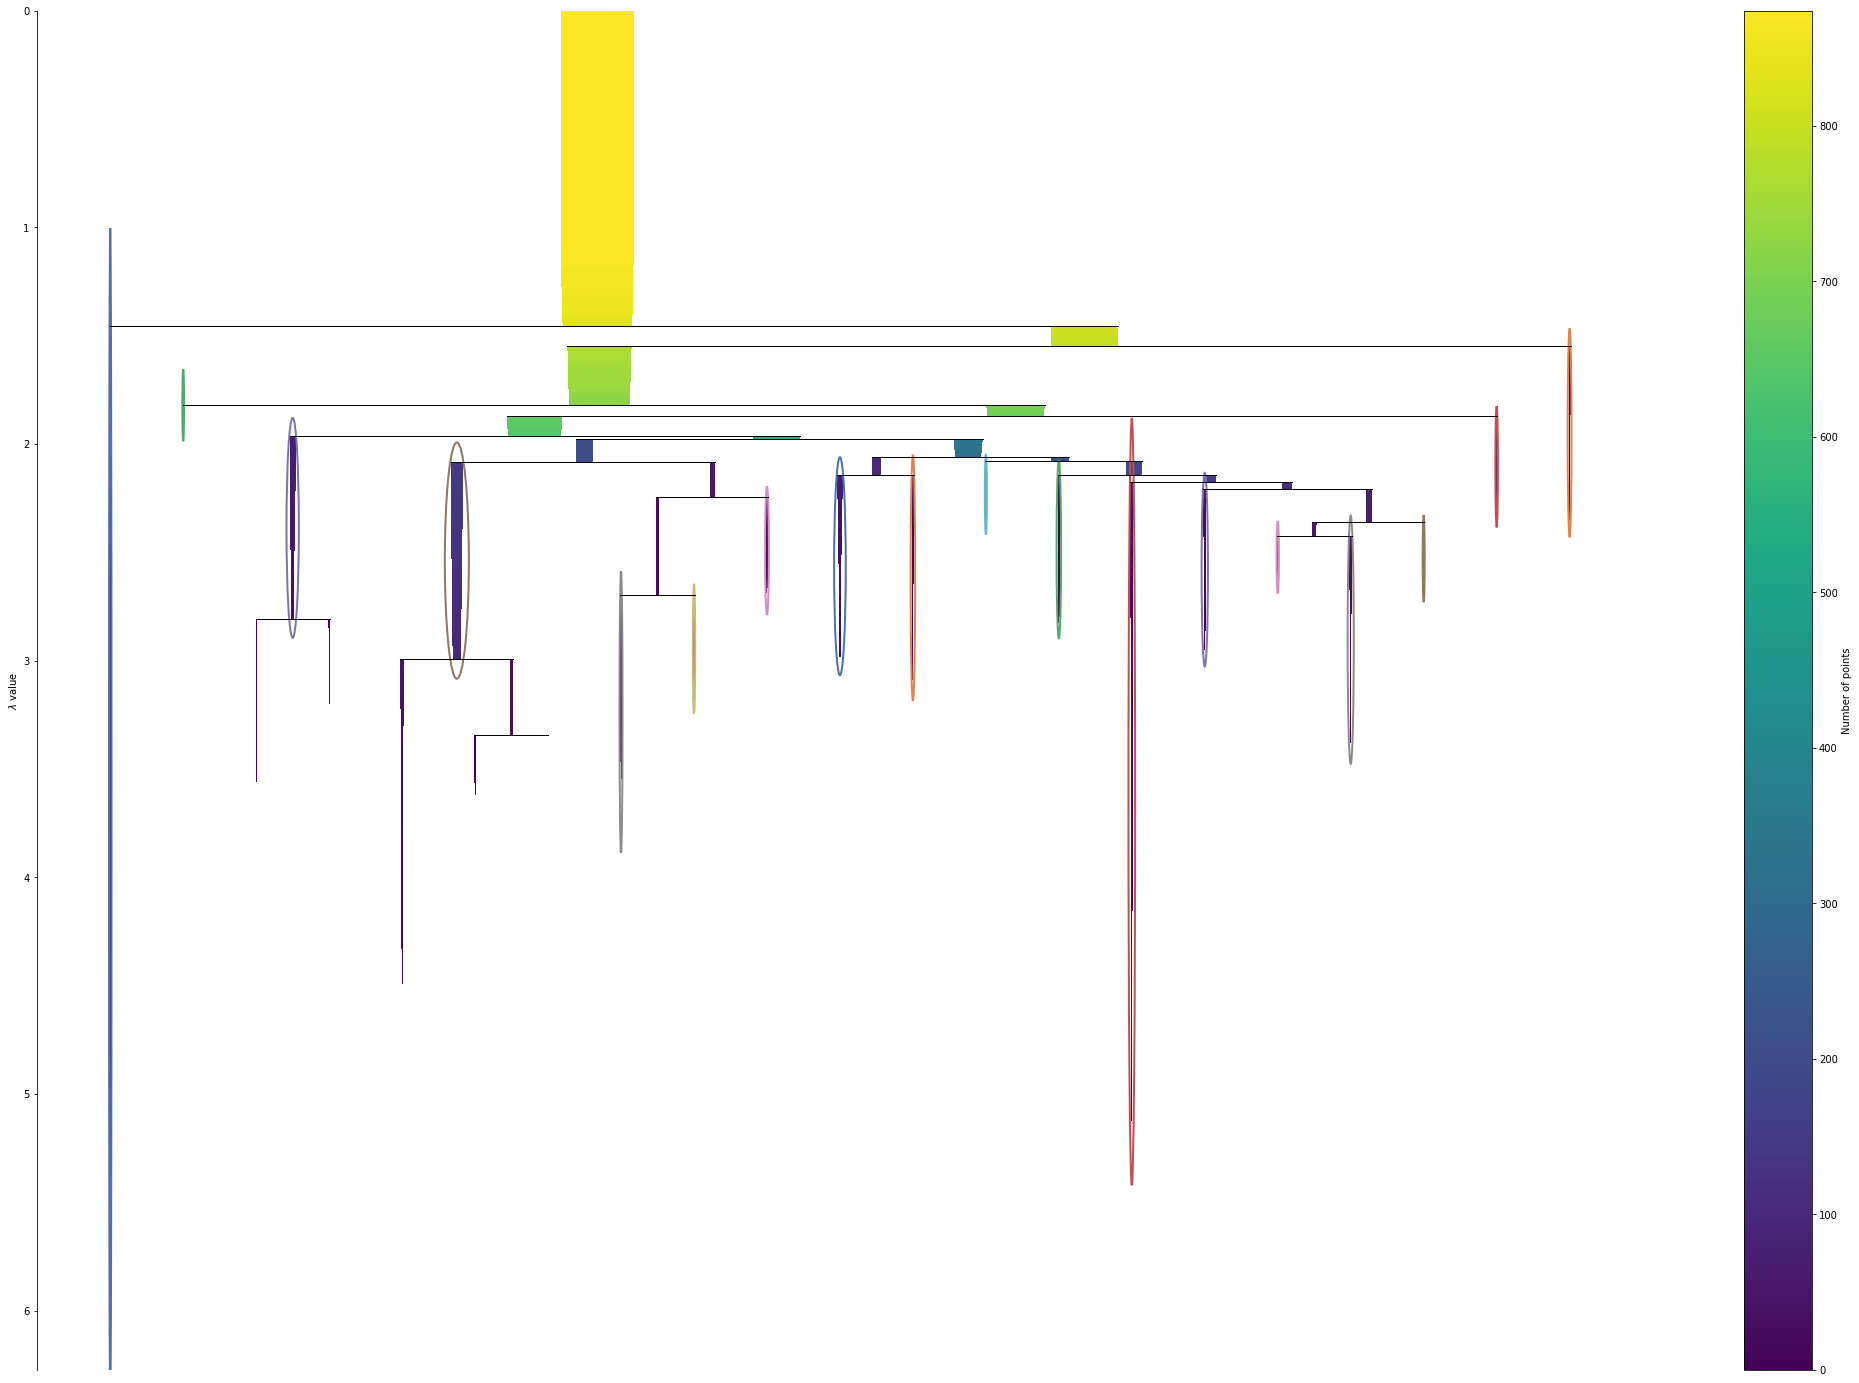

In [ ]:
fig = plt.figure(figsize=(36, 25))
ax = fig.add_subplot(111)
cluster.condensed_tree_.plot(axis = ax, select_clusters=True,
                               selection_palette=sns.color_palette('deep', 18))

In [ ]:
G = cluster.condensed_tree_.to_networkx()
print(G)

DiGraph with 915 nodes and 914 edges


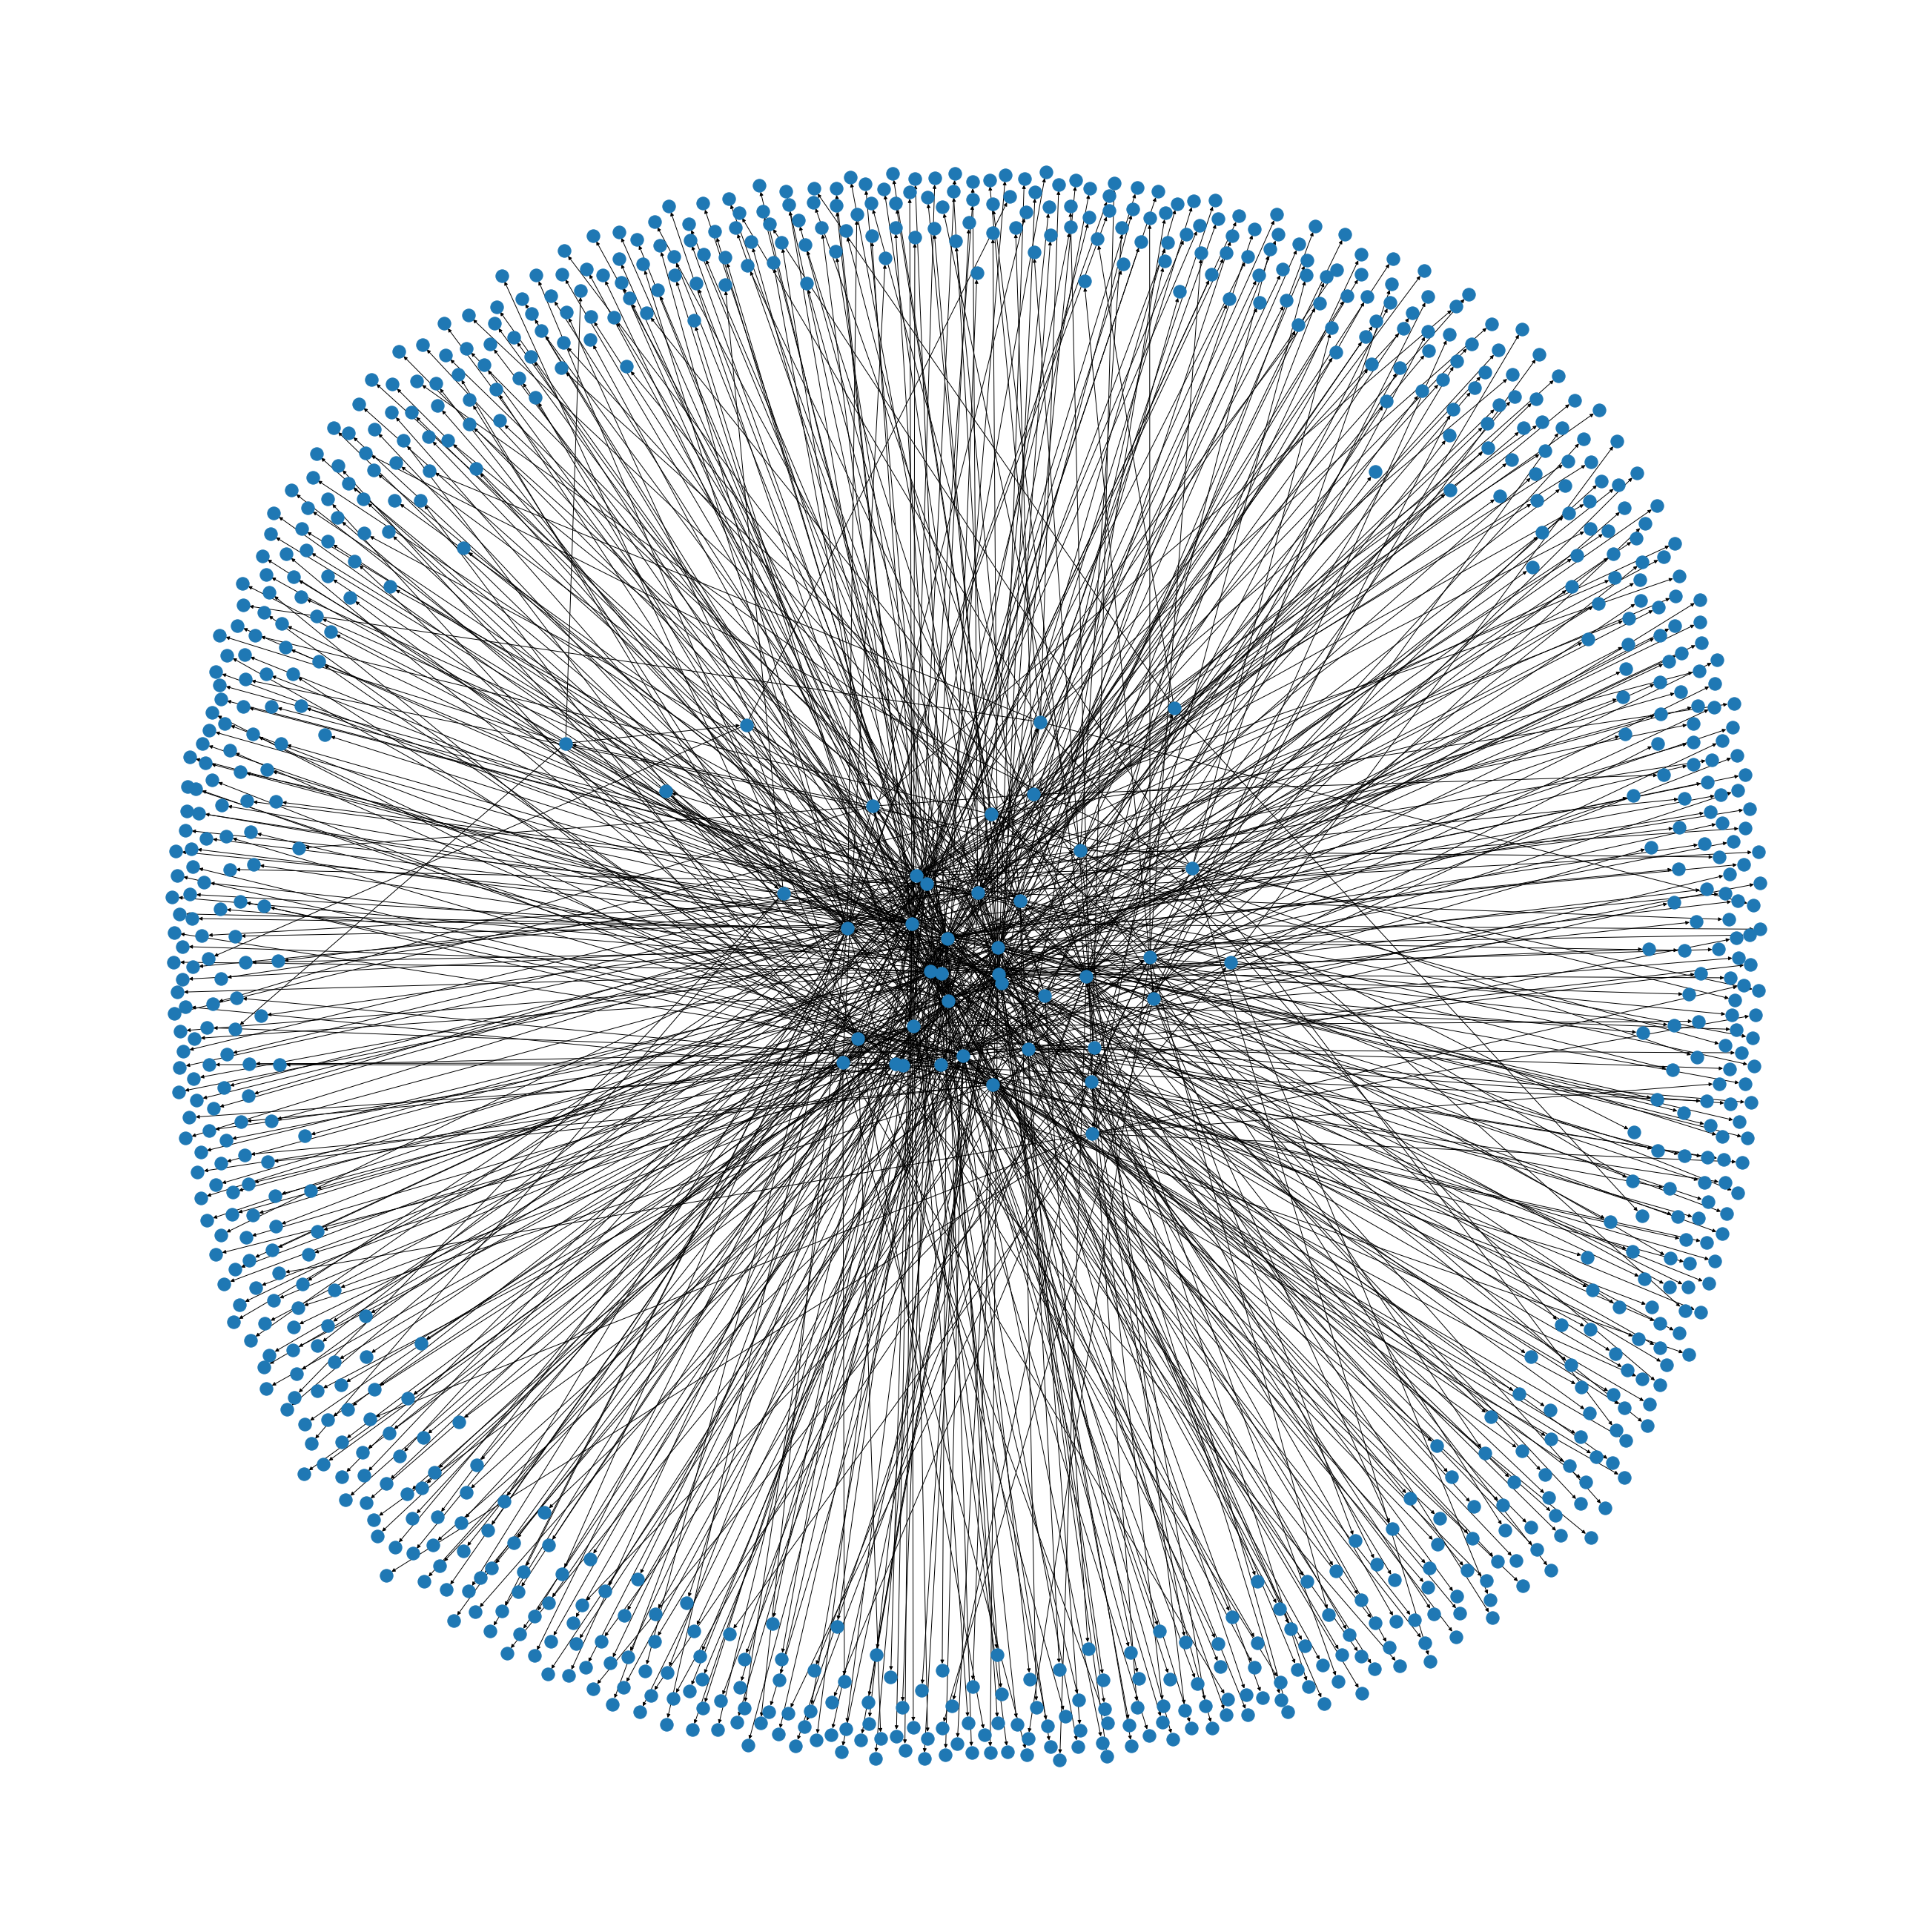

In [ ]:
plt.figure(figsize=(36,36))
nx.draw(G, connectionstyle='arc, rad = 0.05')

In [ ]:
model.topic_words

In [ ]:
model.search_documents_by_keywords(keywords=['gandhara'], num_docs=30)

In [ ]:
def get_all_words(doc_list):
  token_lists = []
  for doc in doc_list:
    token_lists.append(word_tokenize(doc))
  return token_lists

def process_doc(doc_lists):
  token_lists = get_all_words(doc_lists)
  dictionary = corpora.Dictionary(token_lists)
  # convert tokenized documents into a document-term matrix
  corpus = [dictionary.doc2bow(text) for text in token_lists]

  return token_lists, dictionary, corpus

token_lists_u, dictionary_u, corpus_u = process_doc(cleaned_docs_all_upan)

In [ ]:
def get_coherence(model, token_lists, corpus, dictionary, method = 'top2vec', measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if method == 'LDA':
        cm = CoherenceModel(model = model, texts=token_lists, corpus= corpus, dictionary = dictionary,
                            coherence=measure)
    else:
        topics = model.topic_words
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus= corpus, dictionary = dictionary,
                            coherence=measure)
    return cm.get_coherence()

In [ ]:
get_coherence(model, token_lists_u, corpus_u, dictionary_u)

0.6698425374456927

## Bhagavad Gita

In [ ]:
path = '/content/drive/MyDrive/intern-unsw/topicmodelling_vedictexts/assets/gita_cleaned/verses_eknath_easwaran.txt'
with open(path, 'r') as f:
  data_gita = f.read()

In [ ]:
num_words_gita = len(word_tokenize(data_gita))
avg_words = num_words_gita/(len(data_gita.split("\n")))
print(num_words_gita, avg_words)

20299 27.505420054200542


In [ ]:
data_gita_list = data_gita.split("\n")
data_gita_list = [" ".join(word_tokenize(x)) for x in data_gita_list if 'Chapter' not in x and len(x) > 1]
 
data_gita_list = [clean(doc) for doc in data_gita_list]

In [ ]:
len(data_gita_list)

In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model_gita = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, hdbscan_args = hdbscan_args)
model_gita.get_num_topics()

2021-11-14 11:04:50,118 - top2vec - INFO - Pre-processing documents for training
2021-11-14 11:04:50,165 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2021-11-14 11:04:54,868 - top2vec - INFO - Creating joint document/word embedding
2021-11-14 11:05:47,808 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-14 11:05:51,247 - top2vec - INFO - Finding dense areas of documents
2021-11-14 11:05:51,274 - top2vec - INFO - Finding topics


14

In [ ]:
token_lists_g, dictionary_g, corpus_g = process_doc(data_gita_list)

In [ ]:
get_coherence(model_gita, token_lists_g, corpus_g, dictionary_g)

0.7024960502326383

In [ ]:
model_gita.topic_words[12]

array(['sacrifices', 'sacrifice', 'sacrificing', 'devotion', 'mercy',
       'generosity', 'charity', 'worship', 'worships', 'compassion',
       'rituals', 'spiritually', 'spiritual', 'ritual', 'compassionate',
       'appetites', 'suffering', 'sacred', 'nourished', 'divine',
       'dedication', 'devotees', 'kindness', 'sinful', 'blessing',
       'prayers', 'food', 'grace', 'eating', 'sinners', 'immortality',
       'cruelty', 'buddhi', 'fame', 'giving', 'mantram', 'gratification',
       'forgiving', 'greed', 'eat', 'immortal', 'welfare', 'deathless',
       'cravings', 'blessed', 'selfishly', 'inhuman', 'nutritional',
       'goodness', 'dishonor'], dtype='<U15')

In [ ]:
topic_vectors_upan = model.topic_vectors
topic_vectors_gita = model_gita.topic_vectors
print(topic_vectors_upan.shape, topic_vectors_gita.shape)

(18, 512) (14, 512)


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(topic_vectors_upan, topic_vectors_gita)
most_similar = similarity_matrix.argmax(axis=1)

In [ ]:
def bipartite_to_adjacency(A):
     m, n = A.shape
     Z_mm = np.zeros((m,m), dtype=int)
     Z_nn = np.zeros((n,n), dtype=int)
     top_partition = np.concatenate((Z_nn,np.transpose(A)), axis=1)
     bottom_partition = np.concatenate((A,Z_mm), axis=1)
     return np.concatenate((top_partition, bottom_partition))
sim_G = nx.to_networkx_graph(bipartite_to_adjacency(similarity_matrix))

In [ ]:
plt.figure(figsize=(16,16))
nx.draw(sim_G)

In [ ]:
print(sim_G.nodes())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [ ]:
most_similar

array([12,  3,  0,  7,  1,  5, 12,  7,  6,  2,  8,  6,  2, 10,  7,  4,  8,
       12])

In [ ]:
ms_value = similarity_matrix.max(axis=1)
ms_value

array([0.5544671 , 0.8936735 , 0.7713016 , 0.79195726, 0.67446053,
       0.74544024, 0.7181963 , 0.7634048 , 0.6420082 , 0.6839007 ,
       0.7077936 , 0.64409965, 0.75490236, 0.5578065 , 0.6279946 ,
       0.64071155, 0.54570526, 0.587156  ], dtype=float32)

In [ ]:
y_tick = ['Topic-{}'.format(x+1) for x in range(18)]
x_tick = ['Topic-{}'.format(x+1) for x in range(14)]

In [ ]:
sns.set(font_scale=2)

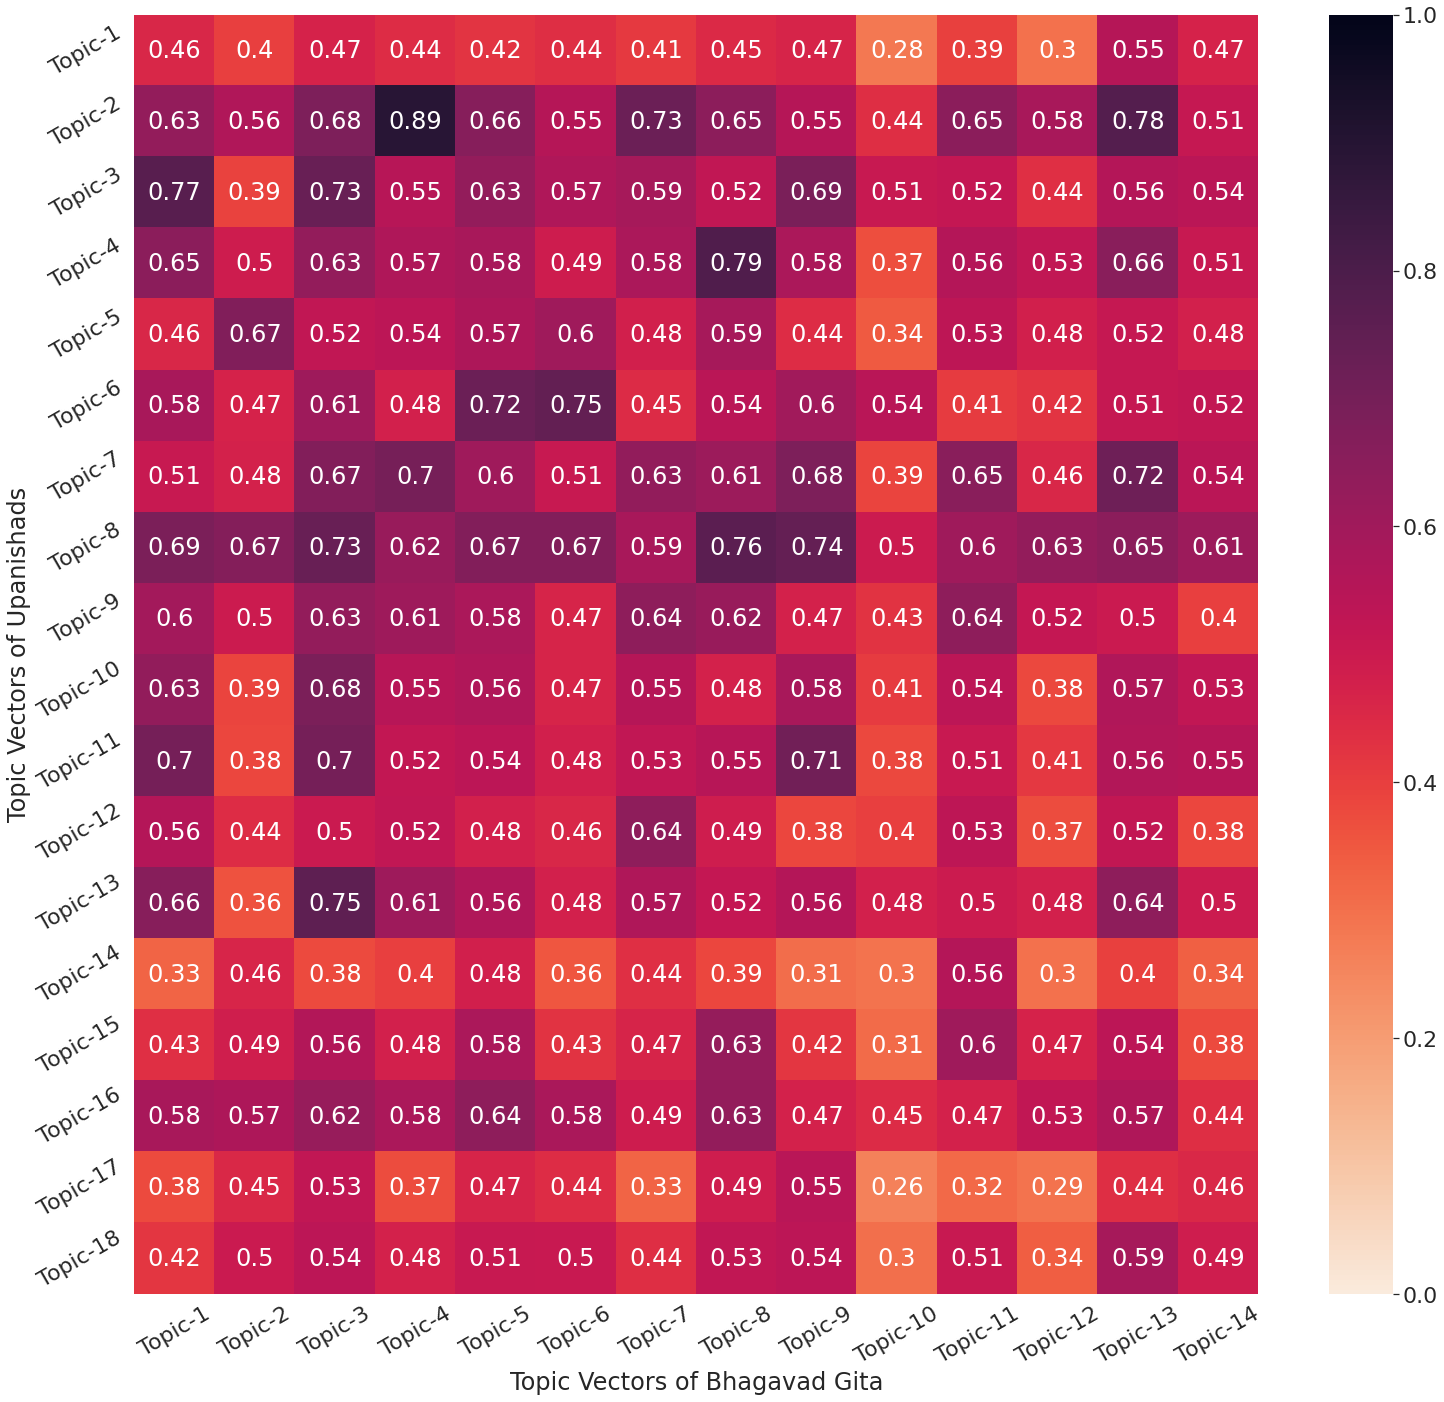

In [ ]:
fig = plt.figure(figsize=(22, 20))
cmap = sns.cm.rocket_r
hm = sns.heatmap(similarity_matrix, annot=True, vmin=0, vmax=1, xticklabels=True, yticklabels=True, cmap = cmap)
_ = hm.set_xticklabels(x_tick, rotation=30)
_ =  hm.set_yticklabels(y_tick, rotation=30)
plt.xlabel("Topic Vectors of Bhagavad Gita")
plt.ylabel("Topic Vectors of Upanishads") 
plt.tight_layout()
plt.savefig("similarity_eaknath.pdf", bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
def get_words(model, num_words = 20, num_topics = 10):
    """
    get n random words from each topics
    """
    reduced_flag = False
    if model.get_num_topics() > num_topics:
      reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_topics)
      reduced_flag = True
    
    topic_words, word_scores, topic_nums = model.get_topics(reduced=reduced_flag)

    return topic_words[:,:num_words], word_scores[:,:num_words], topic_nums

In [ ]:
words, _, _= get_words(model, 10, model.get_num_topics())
words_gita, _, _ = get_words(model_gita, 10, model.get_num_topics())
words_gita

In [ ]:
words_gita[2]

array(['spiritually', 'consciousness', 'cheerfulness', 'spiritual',
       'happiness', 'happier', 'conscious', 'happy', 'spirit',
       'gratification'], dtype='<U15')

In [ ]:
mstg = []
for x in most_similar:
  mstg.append(words_gita[x])
len(mstg)

18

In [ ]:
df = pd.DataFrame({"Topics of Upanishads(top 10 words)":[','.join(list(x)) for x in words], "Most Similar topics in Gita": [','.join(list(x)) for x in mstg], "Similarity Score": list(ms_value)})
df.head()

Topics of Upanishads(top 10 words)  ... Similarity Score
0  hinduism,hindu,buddhism,bhagavad,buddhi,mahabh...  ...         0.554467
1  immortality,immortal,deathlessness,everliving,...  ...         0.893673
2  selfless,selfsame,self,selflessly,selfs,consci...  ...         0.771302
3  loveliness,loving,love,loves,loved,divine,omni...  ...         0.791957
4  asks,asked,ask,divine,buddhism,answered,bhagav...  ...         0.674461

[5 rows x 3 columns]

In [ ]:
df.iloc[1,1]

'immortality,immortal,deathless,mortality,death,dying,mortal,eternal,eternity,mortals'

In [ ]:
with open("my_table.tex", "w") as f:
    f.write("\\begin{tabular}{" + " | ".join(["c"] * len(df.columns)) + "}\n")
    for i, row in df.iterrows():
        f.write(" & ".join([str(x) for x in row.values]) + " \\\\\n")
    f.write("\\end{tabular}")

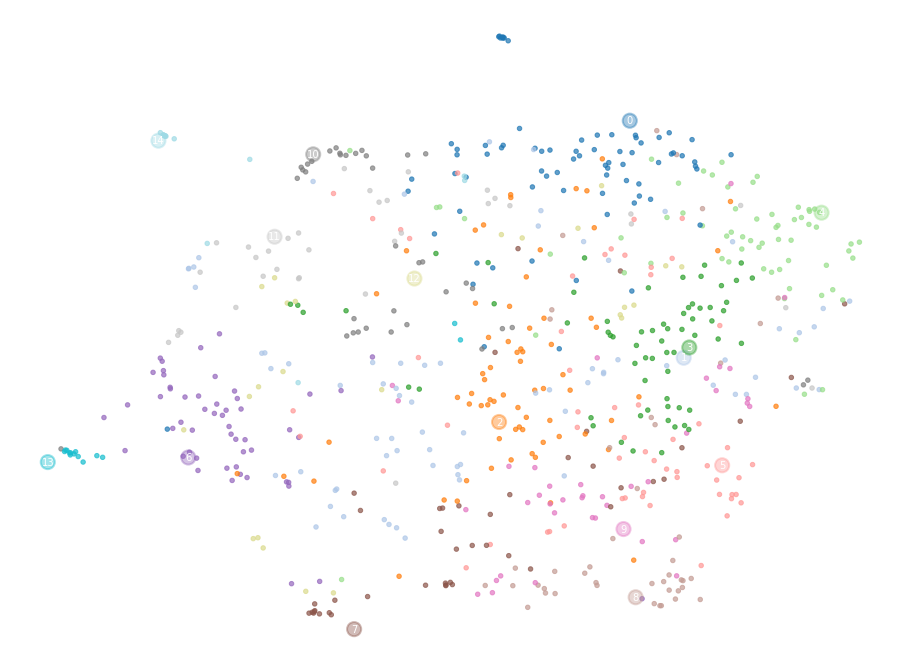

In [ ]:
model.generate_documents_plot(background_color="white")

In [ ]:
topic_words, word_scores, topic_nums = model.get_topics()
topic_words, word_scores, topic_nums = model.get_topics(model.get_num_topics())

for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [ ]:
topic_words

## LDA Model

## Universal Sentence Encoder

In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
hdbscan_args = {'min_cluster_size': 10,
                'min_samples':5,
                'metric': 'euclidean',
                'cluster_selection_method': 'eom'
             }
model_gita_use = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
print(model_gita_use.get_num_topics())

2021-11-14 12:32:54,721 - top2vec - INFO - Pre-processing documents for training
2021-11-14 12:32:54,795 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder-multilingual/3, Total size: 266.88MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder-multilingual/3'.
2021-11-14 12:33:03,801 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 12:33:08,207 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 12:33:11,783 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 12:33:11,810 - top2vec - 

14

In [ ]:
get_coherence(model_gita_use, token_lists_g, corpus_g, dictionary_g)

0.7255051661841652

In [ ]:
model_upan_use = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, hdbscan_args = hdbscan_args)
print(model_upan_use.get_num_topics())
print(get_coherence(model_upan_use, token_lists_u, corpus_u, dictionary_u))

2021-11-14 12:37:07,376 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 12:37:07,486 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 12:37:11,282 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 12:37:18,179 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 12:37:22,525 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 12:37:22,563 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


21
0.674850317093146


In [ ]:
topic_words, word_scores, topic_nums = model_upan_use.get_topics(model_upan_use.get_num_topics())
for topic in topic_nums:
  model_upan_use.generate_topic_wordcloud(topic)

In [ ]:
topic_words_gita_use, word_scores_gita_use, topic_nums_gita_use = model_gita_use.get_topics(model_gita_use.get_num_topics())
for topic in topic_nums_gita_use:
  model_gita_use.generate_topic_wordcloud(topic)

In [ ]:
topic_words_gita_use

## USE-UMAP-KMeans

In [ ]:
kmeans_args = {"n_clusters": 15, "init": "k-means++"}
model_upan_use_km = TopicModel(documents= cleaned_docs_all, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_upan_use_km.get_num_topics())
print(get_coherence(model_upan_use_km, token_lists_u, corpus_u, dictionary_u))

2021-11-14 15:17:27,786 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 15:17:27,904 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 15:17:38,648 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 15:17:45,460 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 15:17:49,813 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 15:17:52,111 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.6862064795710617


In [ ]:
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
kmeans_args = {"n_clusters": 20, 
               "init": "k-means++"
               }
model_upan_use_km = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_upan_use_km.get_num_topics())
print(get_coherence(model_upan_use_km, token_lists_u, corpus_u, dictionary_u))

2021-11-14 16:39:08,869 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 16:39:08,975 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 16:39:12,744 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 16:39:19,233 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 16:39:23,398 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 16:39:24,969 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


20
0.6636149817044875


In [ ]:
kmeans_args = {"n_clusters": 20, 
               "init": "k-means++"
               }
model_gita_use_km = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_gita_use_km.get_num_topics())
print(get_coherence(model_gita_use_km, token_lists_g, corpus_g, dictionary_g))

2021-11-14 16:56:05,947 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 16:56:06,000 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 16:56:10,329 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 16:56:13,601 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 16:56:17,024 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 16:56:18,219 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


20
0.718413861485851


In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
model_gita_use_km = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='universal-sentence-encoder-multilingual', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_gita_use_km.get_num_topics())
print(get_coherence(model_gita_use_km, token_lists_g, corpus_g, dictionary_g))

2021-11-14 16:56:26,679 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 16:56:26,737 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2021-11-14 16:56:30,878 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 16:56:34,287 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 16:56:37,687 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 16:56:38,763 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.7323957403105248


## SBERT-UMAP-Kmeans

In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
model_gita_sb_km = TopicModel(documents= data_gita_list, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_gita_sb_km.get_num_topics())
print(get_coherence(model_gita_sb_km, token_lists_g, corpus_g, dictionary_g))

2021-11-14 17:01:01,065 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 17:01:01,119 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2021-11-14 17:01:28,081 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 17:02:13,365 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 17:02:16,743 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 17:02:17,859 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.720611726701225


In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
model_upan_sb_km = TopicModel(documents= cleaned_docs_all_upan, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_upan_sb_km.get_num_topics())
print(get_coherence(model_upan_sb_km, token_lists_u, corpus_u, dictionary_u))

2021-11-14 17:03:11,067 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2021-11-14 17:03:11,177 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
INFO:top2vec:Downloading distiluse-base-multilingual-cased model
2021-11-14 17:03:14,929 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2021-11-14 17:04:53,104 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2021-11-14 17:04:57,282 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2021-11-14 17:04:58,543 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


15
0.6849348057339407


## Combined Docs

In [ ]:
combined_docs = cleaned_docs_all_upan+data_gita_list
print(len(combined_docs), len(data_gita_list), len(cleaned_docs_all_upan))

1573 699 874


In [ ]:
def get_embeddings_df_2d(model, num_reduced_topics = 10, sigma = None, random_state = 42 ):
    """
    2d plot the documents embedding
    """
    umap_args = {
      "n_neighbors": 15,
      "n_components": 2, # 5 -> 2 for plotting 
      "metric": "cosine",
      "random_state":random_state
      }
    if not sigma:
    	sigma = [3,3] #default value
    umap_data = umap.UMAP(**umap_args).fit_transform(model._get_document_vectors(norm=False))

    #get dataframe of the result 
    result = pd.DataFrame(umap_data, columns=['x_embeddings', 'y_embeddings'])
    result['Labels'] = np.array( ['Topic-'+ str(x+1) if x != -1 else 'outliers' for x in list(model.doc_top) ] )

    #### Hierarchical Topic Reduction ##########################
    new_label = []
    if model.get_num_topics() > num_reduced_topics:
      reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_reduced_topics)
      ######################################

      ###get new labels
      for top_doc in model.doc_top:
        for idx, reduced_list in enumerate(reduced_topic_lists):
          if top_doc in reduced_list:
            new_label.append("Topic-"+str(idx+1))
            break
      ##################################
      result["Labels"] = np.array(new_label)
    else:
      result["Labels"] = result['Labels']

    #remove outliers
    result = result[np.abs(result.x_embeddings-result.x_embeddings.mean()) <= (sigma[0]*result.x_embeddings.std())]
    result = result[np.abs(result.y_embeddings-result.y_embeddings.mean()) <= (sigma[1]*result.y_embeddings.std())]
    return result
# result = get_embeddings_df_2d(model_gita_use_km, sigma = [2.5, 2.5], num_reduced_topics = 10)
# result.shape()

In [ ]:
def plot2d_df(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('UMAP Embedding (dim = 1)')
    ax.set_ylabel('UMAP Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['Labels'])
    for idx, topics in enumerate(result.Labels.unique()):
        ax.scatter(x[result.Labels == topics],y[result.Labels == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.16, 0.77), title="Labels")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

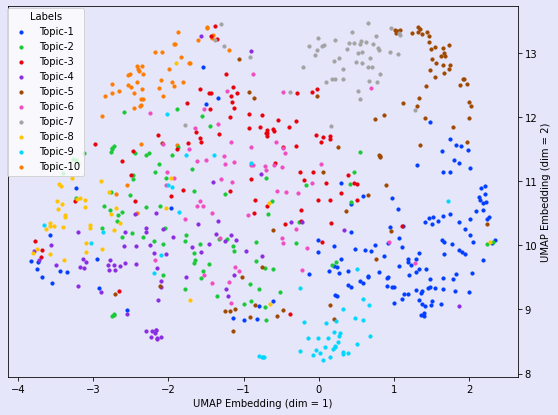

In [ ]:
plot2d_df(result = result,img_name = 'eknath_easwaran_gita_umap_km.pdf')

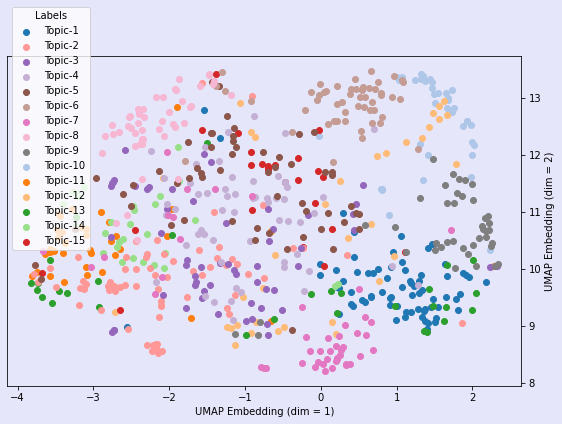

In [ ]:
result_t = get_embeddings_df_2d(model_gita_use_km, sigma = [2.5, 2.5], num_reduced_topics = 15)
# result.head()
plot2d_df(result = result_t, palet = 'tab20',img_name = 'eknath_easwaran_gita_umap_km.pdf')

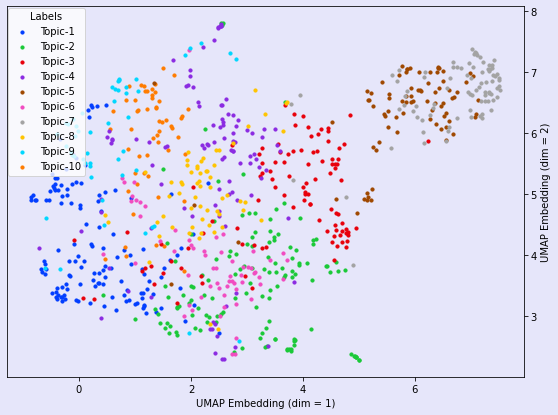

In [ ]:
result_upan = get_embeddings_df_2d(model_upan_use_km, sigma = [2.5, 2.5], num_reduced_topics = 10)
# result.head()
plot2d_df(result = result_upan, palet = 'bright',img_name = 'eknath_easwaran_upan_umap_km.pdf')

In [ ]:
token_lists_c, dictionary_c, corpus_c = process_doc(combined_docs)

In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
umap_args = {'n_neighbors': 10,
             'n_components': 5,
             'metric': 'cosine',
             "random_state": 42
             }
model_c_umap = TopicModel(documents = combined_docs, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', umap_args = umap_args, kmeans_args = kmeans_args)
print(model_c_umap.get_num_topics())
print(get_coherence(model_c_umap, token_lists_c, corpus_c, dictionary_c))

2021-11-17 20:05:51,593 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2021-11-17 20:05:51,733 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model
2021-11-17 20:06:07,089 - top2vec - INFO - Creating joint document/word embedding
2021-11-17 20:08:33,403 - top2vec - INFO - Creating lower dimension embedding of documents
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2021-11-17 20:08:48,337 - top2vec - INFO - Finding dense areas of documents
2021-11-17

15
0.691118928574904


In [ ]:
result_c_umap = get_embeddings_df_2d(model_c_umap, sigma = [2.5, 2.5], num_reduced_topics = 10)
(result_c_umap.head(), result_c_umap.shape)

(   x_embeddings  y_embeddings   Labels
 0     11.109902      8.122833  Topic-4
 1     10.920431      8.291782  Topic-4
 2     10.390152      8.465904  Topic-4
 3     10.654686      8.695951  Topic-4
 4     10.706587      8.403521  Topic-4, (1573, 3))

In [ ]:
a = ['The Upanishads' for x in range(874)]
b = ['The Bhagavad Gita' for x in range(699)]
result_c_umap['docs'] = a+b
result_c_umap.head(), result_c_umap.shape

(   x_embeddings  y_embeddings   Labels            docs
 0     11.109902      8.122833  Topic-4  The Upanishads
 1     10.920431      8.291782  Topic-4  The Upanishads
 2     10.390152      8.465904  Topic-4  The Upanishads
 3     10.654686      8.695951  Topic-4  The Upanishads
 4     10.706587      8.403521  Topic-4  The Upanishads, (1573, 4))

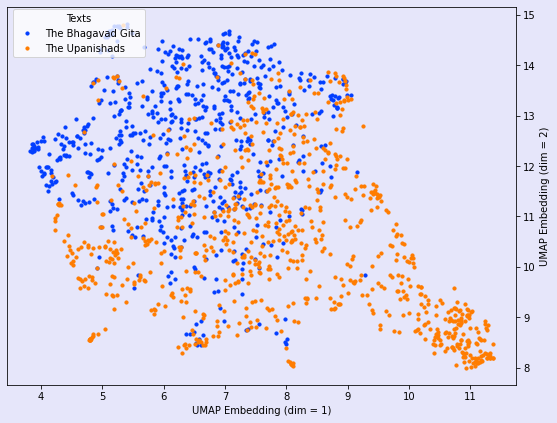

In [ ]:
def plot2d_text(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('UMAP Embedding (dim = 1)')
    ax.set_ylabel('UMAP Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['docs'])
    for idx, topics in enumerate(result.docs.unique()):
        ax.scatter(x[result.docs == topics],y[result.docs == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.28, 0.93), title="Texts")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')
plot2d_text(result = result_c_umap,img_name = 'gita_in_upan.pdf')

## PCA embeddings

In [ ]:
def get_embeddings_df_2d_pca(model, num_reduced_topics = 10, sigma = None, random_state = 42 ):
    """
    2d plot the documents embedding
    """
    pca_args={"n_components": 2, 
          "svd_solver": "auto"}
    if not sigma:
    	sigma = [3,3] #default value
    umap_data = PCA(**pca_args).fit_transform(model._get_document_vectors(norm=False))

    #get dataframe of the result 
    result = pd.DataFrame(umap_data, columns=['x_embeddings', 'y_embeddings'])
    result['Labels'] = np.array( ['Topic-'+ str(x+1) if x != -1 else 'outliers' for x in list(model.doc_top) ] )

    #### Hierarchical Topic Reduction ##########################
    new_label = []
    if model.get_num_topics() > num_reduced_topics:
      reduced_topic_lists = model.hierarchical_topic_reduction(num_topics = num_reduced_topics)
      ######################################

      ###get new labels
      for top_doc in model.doc_top:
        for idx, reduced_list in enumerate(reduced_topic_lists):
          if top_doc in reduced_list:
            new_label.append("Topic-"+str(idx+1))
            break
      ##################################
      result["Labels"] = np.array(new_label)
    else:
      result["Labels"] = result['Labels']

    #remove outliers
    result = result[np.abs(result.x_embeddings-result.x_embeddings.mean()) <= (sigma[0]*result.x_embeddings.std())]
    result = result[np.abs(result.y_embeddings-result.y_embeddings.mean()) <= (sigma[1]*result.y_embeddings.std())]
    return result
# result = get_embeddings_df_2d(model_gita_use_km, sigma = [2.5, 2.5], num_reduced_topics = 10)
def plot2d_df_pca(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('PCA Embedding (dim = 1)')
    ax.set_ylabel('PCA Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['Labels'])
    for idx, topics in enumerate(result.Labels.unique()):
        ax.scatter(x[result.Labels == topics],y[result.Labels == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.16, 0.77), title="Labels")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')

In [ ]:
def plot2d_text_pca(result, palet = 'bright', img_name = 'no_name_2d_plot.pdf'):

    clrs = sns.color_palette(palet).as_hex()
    # color_palette = [cpt for cpt in clrs]
    #palette = sns.color_palette(palet)
    x = result['x_embeddings']
    y = result['y_embeddings']
    # z = result['z_embeddings']
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    
    ax.set_xlabel('PCA Embedding (dim = 1)')
    ax.set_ylabel('PCA Embedding (dim = 2)')

    fig.patch.set_facecolor('lavender')
    ax.set_facecolor('lavender')

    result = result.sort_values(by=['docs'])
    for idx, topics in enumerate(result.docs.unique()):
        ax.scatter(x[result.docs == topics],y[result.docs == topics],label = topics, c = clrs[idx], s = 10)
    
    ax = plt.gca()

    #set y-axes to right side
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
    labels, handles = zip(*natsorted(zip(labels, handles), key=lambda t: t[0]))
    ax.legend(handles, labels, loc='center right', bbox_to_anchor=(0.28, 0.93), title="Texts")
    plt.tight_layout()
    plt.savefig(img_name, bbox_inches = 'tight',dpi = 150, facecolor=fig.get_facecolor(), edgecolor='none')


In [ ]:
combined_docs = cleaned_docs_all_upan + data_gita_list
print(len(combined_docs), len(data_gita_list), len(cleaned_docs_all_upan))

1573 699 874


In [ ]:
kmeans_args = {"n_clusters": 15, 
               "init": "k-means++"
               }
pca_args={"n_components": "mle", 
          "svd_solver": "full"}
model_c = TopicModel(documents = combined_docs, speed='deep-learn', workers=8, min_count = 0, embedding_model='distiluse-base-multilingual-cased', pca_args = pca_args, kmeans_args = kmeans_args)
print(model_c.get_num_topics())
print(get_coherence(model_c, token_lists_c, corpus_c, dictionary_c))

2021-11-17 19:35:53,404 - top2vec - INFO - Pre-processing documents for training
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
2021-11-17 19:35:53,613 - top2vec - INFO - Downloading distiluse-base-multilingual-cased model


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/607 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/341 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/539M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/528 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2021-11-17 19:36:17,699 - top2vec - INFO - Creating joint document/word embedding
2021-11-17 19:38:48,260 - top2vec - INFO - Creating lower dimension embedding of documents
2021-11-17 19:44:36,372 - top2vec - INFO - Finding dense areas of documents
2021-11-17 19:44:38,898 - top2vec - INFO - Finding topics


15
0.6937694569564558


In [ ]:
result_c = get_embeddings_df_2d_pca(model_c, sigma = [5, 5], num_reduced_topics = 10)

In [ ]:
result_c.shape

(1573, 3)

In [ ]:
a = ['The Upanishads' for x in range(874)]
b = ['The Bhagavad Gita' for x in range(699)]
result_c['docs'] = a+ b
result_c.head()

x_embeddings  y_embeddings   Labels            docs
0      0.509382     -0.136276  Topic-4  The Upanishads
1      0.463285     -0.028553  Topic-4  The Upanishads
2      0.544466     -0.083848  Topic-4  The Upanishads
3      0.420431      0.057026  Topic-4  The Upanishads
4      0.329127     -0.009985  Topic-4  The Upanishads

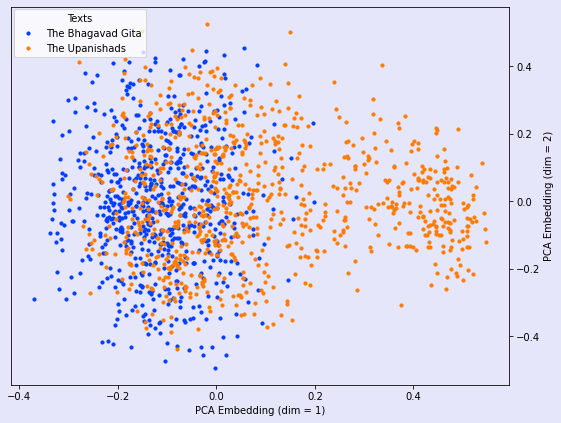

In [ ]:
plot2d_text_pca(result = result_c,img_name = 'gita_in_upan_pca.pdf')

## Tune the hyperparameters